---
## Step 0: Load The Data

In [71]:
# Load pickled data
import pickle

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [72]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

2


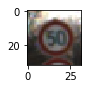

In [73]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

### Pre-process the Data Set (normalization, grayscale, etc.)

In [74]:
from sklearn.utils import shuffle
from skimage import exposure

import matplotlib.pyplot as plot
import cv2

def normalize(x):
    std = np.std(x)
    mean = np.mean(x)
    return (x-mean)/std

def clahe(img):
    img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    clahe = cv2.createCLAHE()
    img = clahe.apply(img)    
    return img.reshape(img.shape + (1,))



def clahe_images(images):
    clahed_images = []
    for index in range(len(images)):
        clahed_images.append(clahe(images[index]))
    return clahed_images
        

    
  

X_train = clahe_images(X_train)
X_valid = clahe_images(X_valid)
X_test = clahe_images(X_test)

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)



print(X_train.shape)

# img = clahe(X_train[220:221][0])
# plot.imshow(img)

# ?img = (X_train[220:221][0])
# plot.imshow(img)


X_train, y_train = shuffle(X_train, y_train)

(34799, 32, 32, 1)


### Model Architecture

In [75]:
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

In [76]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    LeNet.conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    LeNet.conv1   = tf.nn.conv2d(x, LeNet.conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    LeNet.conv1 = tf.nn.relu(LeNet.conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    LeNet.conv1 = tf.nn.max_pool(LeNet.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    LeNet.conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    LeNet.conv2   = tf.nn.conv2d(LeNet.conv1, LeNet.conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    LeNet.conv2 = tf.nn.relu(LeNet.conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    LeNet.conv2 = tf.nn.max_pool(LeNet.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    LeNet.fc0   = flatten(LeNet.conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    LeNet.fc1   = tf.matmul(LeNet.fc0, fc1_W) + fc1_b
    
    #Activation.
    LeNet.fc1    = tf.nn.relu(LeNet.fc1)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    LeNet.fc2    = tf.matmul(LeNet.fc1, fc2_W) + fc2_b
    
    #Activation.
    LeNet.fc2    = tf.nn.relu(LeNet.fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(LeNet.fc2, fc3_W) + fc3_b
    
    return logits

In [77]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [78]:
rate = 0.003
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [79]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [80]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

        training_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.925

EPOCH 1 ...
Training Accuracy = 0.964

EPOCH 2 ...
Validation Accuracy = 0.939

EPOCH 2 ...
Training Accuracy = 0.983

EPOCH 3 ...
Validation Accuracy = 0.934

EPOCH 3 ...
Training Accuracy = 0.987

EPOCH 4 ...
Validation Accuracy = 0.940

EPOCH 4 ...
Training Accuracy = 0.990

EPOCH 5 ...
Validation Accuracy = 0.943

EPOCH 5 ...
Training Accuracy = 0.990

EPOCH 6 ...
Validation Accuracy = 0.928

EPOCH 6 ...
Training Accuracy = 0.979

EPOCH 7 ...
Validation Accuracy = 0.934

EPOCH 7 ...
Training Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.951

EPOCH 8 ...
Training Accuracy = 0.995

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 9 ...
Training Accuracy = 0.994

EPOCH 10 ...
Validation Accuracy = 0.950

EPOCH 10 ...
Training Accuracy = 0.994

EPOCH 11 ...
Validation Accuracy = 0.955

EPOCH 11 ...
Training Accuracy = 0.996

EPOCH 12 ...
Validation Accuracy = 0.942

EPOCH 12 ...
Training Accuracy = 0.987

EPOCH 13 ...
Validati

In [81]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.932


---

## Step 3: Test a Model on New Images


### Load and Output the Images

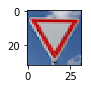

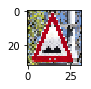

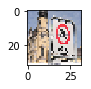

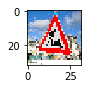

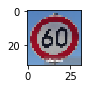

In [138]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plot
import random

%matplotlib inline
web_x=[]
web_y=[13,22,0,25,3]

def readWebImages(shape=(32,32), resize=False):
    global web_x
    web_x=[]
    web_x.append(cv2.resize(cv2.imread("./web-images/_13_1.png", cv2.IMREAD_COLOR), shape) if resize else cv2.imread("_13_1.png", cv2.IMREAD_COLOR))
    web_x.append(cv2.resize(cv2.imread("./web-images/_22.png", cv2.IMREAD_COLOR), shape))
    web_x.append(cv2.resize(cv2.imread("./web-images/_0.jpg", cv2.IMREAD_COLOR), shape))
    web_x.append(cv2.resize(cv2.imread("./web-images/_25.jpg", cv2.IMREAD_COLOR), shape))
    web_x.append(cv2.resize(cv2.imread("./web-images/_3.jpg", cv2.IMREAD_COLOR), shape))


readWebImages(shape=(32,32), resize=True)    
for index in range(len(web_x)):
    image = web_x[index]
    
    b,g,r = cv2.split(image)
    image = cv2.merge([r,g,b])

    
    plot.figure(figsize=(1,1))
    plot.imshow(image.squeeze())

### Predict the Sign Type for Each Image

In [139]:
web_x = clahe_images(web_x)
web_x = normalize(web_x)

### Analyze Performance

In [140]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(web_x, web_y)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [141]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(image):
    b,g,r = cv2.split(image)
    image = cv2.merge([r,g,b])

    plot.figure(figsize=(1,1))
    plot.imshow(image.squeeze())

def autolabel(rects, ax, classes, class_names):
    """
    Attach a text label above each bar displaying its height
    """
    for index in range(len(rects)):
        rect = rects[index]
        width = rect.get_width()
        #y = rect.get_x() + rect.get_width()/2.
        y = rect.get_y() + rect.get_height()/2.
        x = 1.05*width
#         x = 0.6
#         x = rect.get_x() + rect.get_width()
        ax.text(x, y,
                '%s' % class_names[classes[index]],
                ha='center', va='center')   
        
def softmaxvisuals(classes, probabilities, class_names):
    N = len(classes)
    ind = np.arange(N)  # the y locations
    height = 0.75       # the height of the bars

    fig, ax = plt.subplots()
    left = np.zeros(N)
    rects = ax.barh(left=left, bottom=ind, width=probabilities, height=height, color='g')    

    autolabel(rects, ax, classes, class_names)
    plt.show()

    

def readCSVFile():    
    import csv
    class_names={}
    with open('./data/signnames.csv', 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            key = row[0]
            if(key.isdigit()):
                class_names[int(key)] = row[1]

    return class_names

TopKV2(values=array([[  1.00000000e+00,   1.43140151e-15,   7.54533268e-19,
          8.15881519e-21,   3.36193787e-21],
       [  9.84601736e-01,   1.37891797e-02,   1.23340229e-03,
          9.67738815e-05,   7.66032317e-05],
       [  2.21645772e-01,   1.24549553e-01,   1.04162887e-01,
          8.25431272e-02,   7.86986202e-02],
       [  9.31699038e-01,   3.09425462e-02,   1.60742141e-02,
          5.00533357e-03,   4.91674198e-03],
       [  9.99999404e-01,   3.12262017e-07,   2.04978107e-07,
          5.02125763e-09,   4.67114081e-09]], dtype=float32), indices=array([[13,  5,  1, 34,  4],
       [22, 37, 39, 21, 24],
       [ 0, 40,  4, 11, 38],
       [25, 12, 30, 37, 24],
       [ 3,  2,  5, 28, 29]], dtype=int32))


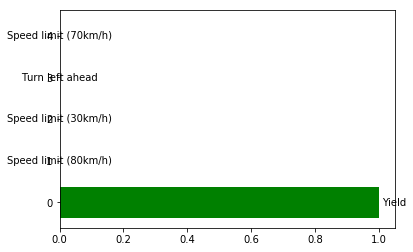

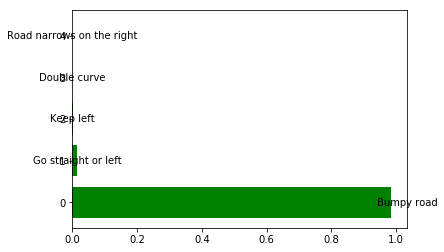

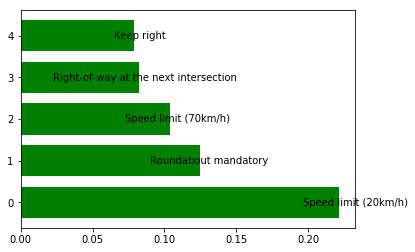

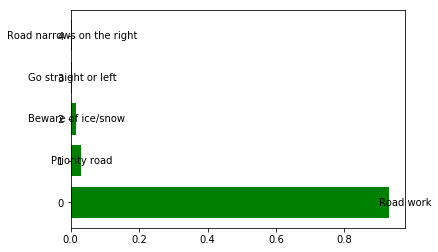

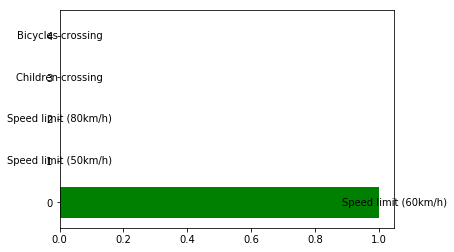

In [142]:
softmax = tf.nn.softmax(logits=logits)
    
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    TopKV2 = sess.run(tf.nn.top_k(softmax, k=5), feed_dict={x: web_x, y: web_y})
    print(TopKV2)
    class_names = readCSVFile()
    readWebImages(shape=(512,512))
    for index in range(len(TopKV2.indices)):
#         show_image(web_x[index].squeeze())
        softmaxvisuals(TopKV2.indices[index], TopKV2.values[index], class_names)

In [114]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

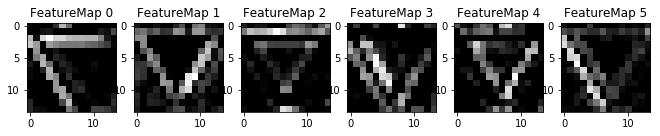

In [115]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image = web_x[0] 
    outputFeatureMap(web_x, LeNet.conv1)

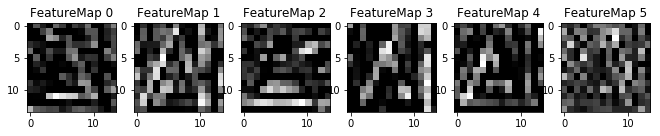

In [116]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image = web_x[1] 
    outputFeatureMap([image], LeNet.conv1)

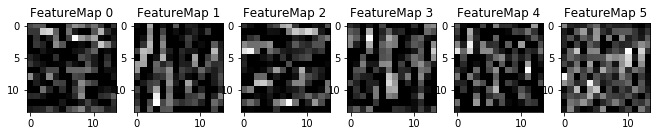

In [117]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image = web_x[2] 
    outputFeatureMap([image], LeNet.conv1)

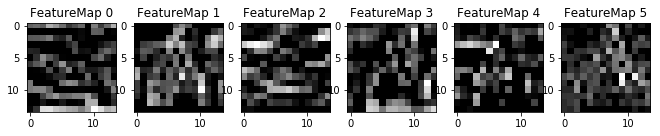

In [118]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image = web_x[3] 
    outputFeatureMap([image], LeNet.conv1)

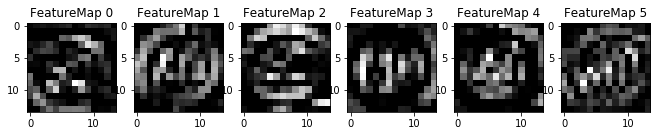

In [119]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    image = web_x[4] 
    outputFeatureMap([image], LeNet.conv1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def showVisualForSamples(title, y_values):
    d={}
    for k in y_values:
        if k in d:
            d[k] += 1
        else:
            d[k] = 1
    #print(d)        

    N = len(d)
    ind = np.arange(N)  # the x locations
    width = 0.35       # the width of the bars

    rects = plt.bar(ind, d.values(), align='center', alpha=0.5)
    #plt.xticks(ind, d.values())
    plt.ylabel('No of samples')
    plt.title(title)
    plt.show()
    
showVisualForSamples(title='No of training samples per class', y_values=y_train)    
showVisualForSamples(title='No of validation samples per class', y_values=y_valid)    
showVisualForSamples(title='No of test samples per class', y_values=y_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def showVisualForSamples(title, y_values):
    d={}
    for k in y_values:
        if k in d:
            d[k] += 1
        else:
            d[k] = 1
    #print(d)        

    N = len(d)
    ind = np.arange(N)  # the x locations
    width = 0.35       # the width of the bars

    rects = plt.bar(ind, d.values(), align='center', alpha=0.5)
    #plt.xticks(ind, d.values())
    plt.ylabel('No of samples')
    plt.title(title)
    plt.show()
    
showVisualForSamples(title='No of training samples per class', y_values=y_train)    
showVisualForSamples(title='No of validation samples per class', y_values=y_valid)    
showVisualForSamples(title='No of test samples per class', y_values=y_test)